# <div style="text-align:center; color:#4a235a"> QUICKSTART</div>


## Table of Contents

1. [Introduction](#1)
2. [Setup](#2)
3. [Working with Data](#3)
4. [Creating models](#4)
5. [Optimizing the model parameters](#5)
6. [Saving models](#6)
7. [Loading models](#7)
8. [Making predictions](#8)
9. [Annex](#annex) <br>
    9.1. [Loss per batch](#A) 
10. [References](#references)


<a name="1"></a>
## <font color='#5b2c6f'>1. Introduction</font>

This section runs through the API for common tasks in machine learning. 

<a name="2"></a>
## <font color='#5b2c6f'>2. Setup </font>

In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# seed
torch.manual_seed(42)

<a name="3"></a>
## <font color='#5b2c6f'>3. Working with data </font>

PyTorch has two primitives to work with data: 

- torch.utils.data.DataLoader
    - Wraps an iterable around the Dataset
- torch.utils.data.Dataset. 
    - Stores the samples and their corresponding labels


PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO... In this tutorial, we use the FashionMNIST dataset. 

Every TorchVision Dataset includes two arguments: 
- transform
    - to modify samples
- target_transform
    - to modify labels

In [4]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
type(training_data), type(test_data)

(torchvision.datasets.mnist.FashionMNIST,
 torchvision.datasets.mnist.FashionMNIST)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports:

- Automatic batching.
- Sampling
- Shuffling
- Multiprocess data loading. 

Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [9]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") # batch size, #channels (1 grey scales), height, width
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


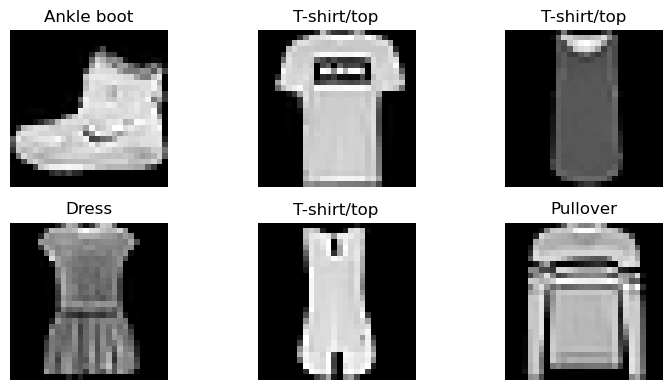

In [11]:
# Get a batch from the train dataloader
images, labels = next(iter(train_dataloader))

# FashionMNIST class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the first 6 images with labels
plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


<a name="4"></a>
## <font color='#5b2c6f'> 4. Creating models </font>

To define a neural network in PyTorch:

- we create a class that inherits from nn.Module. 
- We define the layers of the network in the __init__ function.
- We specify how data will pass through the network in the forward function. 

To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [13]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


<a name="5"></a>
## <font color='#5b2c6f'> 5. Optimizing the model parameters </font>

To train a model, we need a loss function and an optimizer.

(maybe a draw)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.


**Pseudocode**

```
Function train(dataloader, model, loss_fn, optimizer):

  Set size as the total number of samples in the dataset
  Set num_batches as the total number of batches
  Set model to training mode
  Initialize total_loss to 0

  For each batch, (X, y) in dataloader:
    Move X and y to the selected device
    Compute pred by passing X through the model
    Compute loss between pred and y

    Perform backpropagation:
      Call loss.backward()
      Update model weights with optimizer.step()
      Reset gradients with optimizer.zero_grad()

    Add current loss to total_loss

    If current batch is a multiple of 100:
      Print current loss and training progress

  Compute average loss across all batches
  Return average loss
```


In [28]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Trains a PyTorch model for one epoch on the given dataloader (for one epoch).

    Args:
        dataloader (DataLoader): DataLoader providing training data in batches.
        model (nn.Module): The neural network model to train.
        loss_fn (Callable): Loss function to evaluate prediction error.
        optimizer (Optimizer): Optimizer used to update model parameters.

    Returns:
        float: Average loss over all batches in the epoch.
    
    Notes:
        - Moves input and target tensors to the specified device.
        - Prints loss and progress every 100 batches.
    """
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    total_loss = 0  # Track total loss for epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()  # Accumulate loss

        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{(batch + 1) * len(X):>5d}/{size:>5d}]")

    avg_loss = total_loss / num_batches  # Compute average loss for epoch
    return avg_loss  # Return single loss value per epoch

We also check the model’s performance against the test dataset to ensure it is learning.

In [22]:
def test(dataloader, model, loss_fn):
    """
    Evaluates a PyTorch model on the given dataloader.

    Args:
        dataloader (DataLoader): DataLoader providing test/validation data in batches.
        model (nn.Module): The trained model to evaluate.
        loss_fn (Callable): Loss function to compute the evaluation loss.

    Returns:
        float: Average loss over all batches in the evaluation set.
    
    Notes:
        - Runs in evaluation mode with gradient computation disabled.
        - Calculates both average loss and overall accuracy.
        - Prints accuracy and average loss after evaluation.
    """
    
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).item()
            total_loss += loss  # Accumulate loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = total_loss / num_batches  # Compute average loss for epoch
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_loss  # Return single loss value per epoch

<b> <font color='darkblue'> Note </font> </b>

The previous loss calculation per epoch does take into account the possibility that the last batch may have a different size. Here's how it works:

**Explanation:**

- num_batches: The number of batches in the dataloader. This is calculated by len(dataloader), and it includes the last batch, regardless of whether it’s the full batch size or smaller.

- Accumulation of loss: The code accumulates the loss from each batch (loss.item()) and then averages it by dividing by num_batches.

If the last batch is smaller (i.e., not a full batch), the total loss is still accumulated for that batch, and the average loss is computed by dividing by the total number of batches, including the last (potentially smaller) batch. This ensures that the calculation for the average loss over the epoch is correct, even with a smaller last batch.


**Potential edge cases:**
If the last batch is significantly smaller than the others, this could slightly skew the average loss. However, in most cases, the effect is negligible because it's just one batch out of many.

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

Epoch 1
-------------------------------
loss: 1.311821  [   64/60000]
loss: 1.294440  [ 6464/60000]
loss: 1.127901  [12864/60000]
loss: 1.237016  [19264/60000]
loss: 1.116662  [25664/60000]
loss: 1.142137  [32064/60000]
loss: 1.161288  [38464/60000]
loss: 1.094528  [44864/60000]
loss: 1.133796  [51264/60000]
loss: 1.050688  [57664/60000]
Test Error: 
 Accuracy: 63.9%, Avg loss: 1.077764 

Epoch 2
-------------------------------
loss: 1.145459  [   64/60000]
loss: 1.146388  [ 6464/60000]
loss: 0.963744  [12864/60000]
loss: 1.105090  [19264/60000]
loss: 0.987664  [25664/60000]
loss: 1.014246  [32064/60000]
loss: 1.051577  [38464/60000]
loss: 0.984122  [44864/60000]
loss: 1.028189  [51264/60000]
loss: 0.957368  [57664/60000]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.977212 

Done!


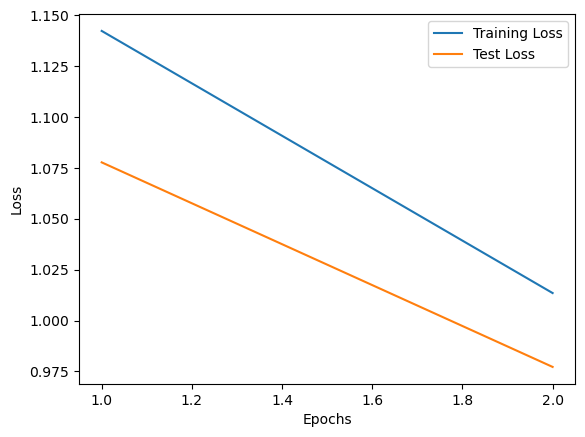

In [23]:
# Run training and store loss values
epochs = 2
train_loss_history = []
test_loss_history = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)

    train_loss_history.append(train_loss)  # Collect average training loss per epoch
    test_loss_history.append(test_loss)  # Collect average test loss per epoch

print("Done!")

# Plot loss per epoch
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), test_loss_history, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


<a name="6"></a>
## <font color='#5b2c6f'> 6. Saving models </font>

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [25]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


<a name="7"></a>
## <font color='#5b2c6f'> 7. Loading models </font>

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [26]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

<a name="8"></a>
## <font color='#5b2c6f'> 8. Making predictions </font>

This model can now be used to make predictions.

In [27]:
model.eval() # set model in evaluation mode

x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


<a name="annex"></a>
## <font color='#5b2c6f'> Annex </font>

<a name="A"></a>
### <font color='#a04000'> A. Loss per batch </font>

Previously, we computed the loss per epoch by averaging the sum of losses over the number of batches, but we can also compute the loss for every individual batch.

Epoch 1
-------------------------------
loss: 1.032287  [   64/60000]
loss: 1.059027  [ 6464/60000]
loss: 0.874670  [12864/60000]
loss: 1.043851  [19264/60000]
loss: 0.936147  [25664/60000]
loss: 0.964234  [32064/60000]
loss: 1.023047  [38464/60000]
loss: 0.961613  [44864/60000]
loss: 1.011955  [51264/60000]
loss: 0.954725  [57664/60000]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.977212 

Epoch 2
-------------------------------
loss: 1.032287  [   64/60000]
loss: 1.059027  [ 6464/60000]
loss: 0.874670  [12864/60000]
loss: 1.043851  [19264/60000]
loss: 0.936147  [25664/60000]
loss: 0.964234  [32064/60000]
loss: 1.023047  [38464/60000]
loss: 0.961613  [44864/60000]
loss: 1.011955  [51264/60000]
loss: 0.954725  [57664/60000]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.977212 

Done!


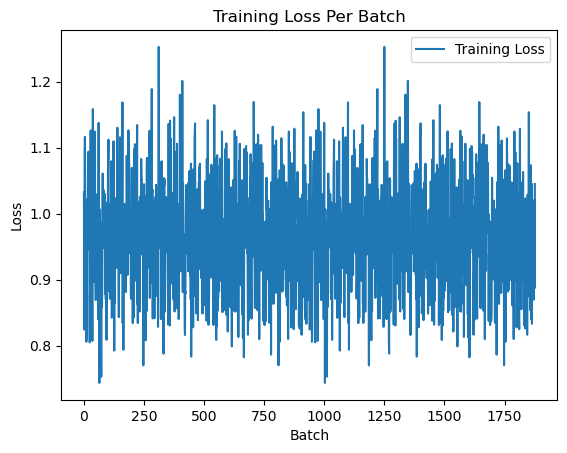

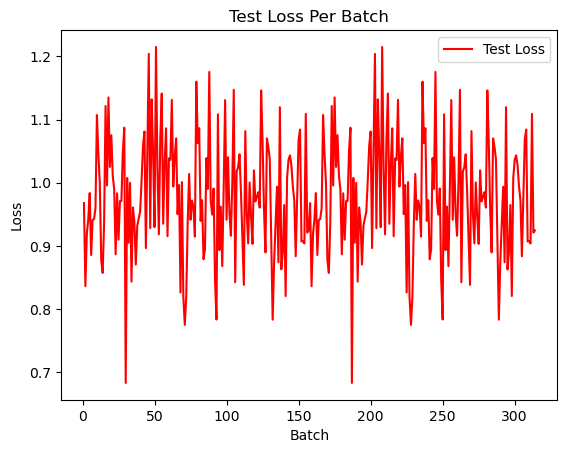

In [30]:
# losses per batch
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_losses = []  # Store training loss

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())  # Save loss value

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return train_losses  # Return list of losses

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    test_losses = []  # Store test loss

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).item()
            test_loss += loss
            test_losses.append(loss)  # Save loss value
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_losses  # Return list of losses

# Run training and store loss values
epochs = 2
train_loss_history = []
test_loss_history = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses = train(train_dataloader, model, loss_fn, optimizer)
    test_losses = test(test_dataloader, model, loss_fn)

    train_loss_history.extend(train_losses)  # Collect training loss
    test_loss_history.extend(test_losses)  # Collect test loss

print("Done!")


# Plot training loss per batch
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss Per Batch")
plt.legend()
plt.show()

# Plot test loss per batch
plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, label="Test Loss", color='red')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Test Loss Per Batch")
plt.legend()
plt.show()


We can observe that the loss per batch is much more volatile than the loss per epoch, as it fluctuates significantly more.

It's generally true that loss per batch tends to be more volatile than the loss per epoch. Here’s why:

- Loss per batch: The loss for each individual batch can fluctuate significantly because each batch might contain a different subset of data. Some batches might be more difficult for the model to predict, leading to larger loss values, while others might be easier, resulting in smaller losses.

- Loss per epoch: The loss averaged over an entire epoch (i.e., all batches) tends to be smoother because it's an aggregate of many batch losses. The individual fluctuations from each batch tend to cancel out over time, providing a more stable estimate of how well the model is learning.

**Summary:**
- Per batch loss is noisy due to the inherent variation in data subsets.

- Per epoch loss is more stable because it's averaged across many batches, reducing the impact of any single outlier.

This is a common observation in training neural networks, where you often track the average loss per epoch for a more reliable measure of progress.

Tracking **loss per batch** in addition to **loss per epoch** can be useful in several scenarios, especially when you're looking for **more granular insights** during training. Here are some cases where it might be beneficial:

**1. Identifying Learning Instability or Divergence**
   - **Use case**: If the loss per batch fluctuates dramatically, it might signal that the model is having difficulty learning from certain subsets of the data or is encountering numerical instability.
   - **Example**: If the model’s loss per batch suddenly increases drastically after a few batches, it could indicate issues like high learning rates or a poor optimization step, which could lead to model divergence.

**2. Monitoring Training Progress in Real-Time**
   - **Use case**: During training, observing loss per batch helps you detect problems early. It’s particularly useful in scenarios where you want to adjust hyperparameters (like learning rate) or fine-tune the training process on the fly.
   - **Example**: If the loss per batch remains consistently high or low across several batches, it might suggest the model is either underfitting or overfitting, which could require intervention before the end of the epoch.

**3. Learning Rate Schedules or Adaptive Optimizers**
   - **Use case**: If you're using **learning rate schedules** or adaptive optimizers (like Adam, Adagrad, etc.), tracking loss per batch can help you visualize the impact of changes in learning rate and fine-tune the optimizer settings.
   - **Example**: If you're reducing the learning rate progressively and observe that loss per batch stabilizes or decreases, you might be able to optimize the learning rate schedule more effectively.

**4.Diagnosing Batch Size Effects**
   - **Use case**: Tracking loss per batch can help identify if the **batch size** is too large or too small. Larger batches tend to average out noise, but smaller batches might show more variability.
   - **Example**: If the loss per batch fluctuates wildly, it might suggest that the batch size is too small, and increasing it could help stabilize the training process.

**5. Detecting Data Issues (Outliers, Class Imbalance, etc.)**
   - **Use case**: Tracking loss per batch can help identify if certain data batches are problematic, such as having outliers, noisy data, or class imbalances that lead to higher losses.
   - **Example**: If a few batches have significantly higher loss values, it might be an indication of class imbalance or data quality issues that need to be addressed (e.g., through data augmentation, balancing, or cleaning).

**6. Debugging and Experimentation**
   - **Use case**: When experimenting with different model architectures, data preprocessing, or augmentation strategies, tracking the loss per batch can help you understand how each change affects the training dynamics at a finer level.
   - **Example**: If you're testing a new model architecture, looking at how the loss per batch evolves can help you determine whether the model is learning properly or whether it's getting stuck in certain regions of the parameter space.

**7. Visualizing Early Stages of Training**
   - **Use case**: In the early stages of training, loss per batch can be more informative for understanding how quickly the model is adapting to the data.
   - **Example**: If the model quickly reduces the loss per batch in the first few epochs, it suggests that the model is learning efficiently from the data. If the loss remains stagnant, it might signal problems with the model or optimizer choice.

**8. Fine-Tuning Pretrained Models**
   - **Use case**: When fine-tuning a pretrained model, loss per batch might help you track if the learning rate is too high (causing instability) or too low (causing very slow learning).
   - **Example**: If fine-tuning is occurring but the loss per batch doesn’t decrease significantly, the learning rate may need to be adjusted.

---

<b> <font color='blue'> Summary </font> </b>

Tracking **loss per batch** provides **more immediate feedback** about the learning process and can help with:
- **Real-time debugging and adjustments** (e.g., learning rate tuning)
- **Identifying training issues early** (e.g., instability, class imbalance)
- **Understanding the impact of hyperparameters** (e.g., batch size, optimizer settings)
  
On the other hand, **loss per epoch** gives you a smoother, more **overall view** of how the model is performing across the entire dataset, making it easier to track general trends in training.

In practice, it's often used in combination, with **loss per batch** providing deeper insights and **loss per epoch** offering the overall performance measure.


<a name="references"></a>
## <font color='#5b2c6f'> References </font>

[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)